In [38]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [84]:
# ---------------- CONFIG ----------------
V_CUTOFF = 2.7
CAPACITY_MIN_AH = 1.0
NOMINAL_AH = 2.0

BINS = 20
M_RESAMPLE = 200

LAMBDA_Q = 0.05
LAMBDA_E = 0.02

BATCH_SIZE = 128
EPOCHS = 55
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_device_name(0))

Tesla T4


In [40]:
metadata=pd.read_csv("/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv")

print(metadata.head())
print(metadata.columns)
print(metadata["type"].value_counts())

        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

             Capacity                   Re                  Rct  
0  1.6743047446975208                  NaN                  NaN  
1                 NaN  0.05605783343888099  0.20097016584458333  
2                 NaN     

In [41]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")
excluded_batteries = ["B0049", "B0050", "B0051", "B0052"]

metadata["battery_id"] = metadata["battery_id"].astype(str)

discharge_meta = metadata[
    (metadata["type"] == "discharge") &
    (~metadata["battery_id"].isin(excluded_batteries))
].copy()

discharge_meta["cycle_number"] = (
    discharge_meta.groupby("battery_id").cumcount() + 1
)

print("Total discharge cycles:", len(discharge_meta))


Total discharge cycles: 2694


In [42]:
main_rows = []
phys_rows = []

for _, row in tqdm(discharge_meta.iterrows(), total=len(discharge_meta)):

    file_path = os.path.join(
        "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data",
        row["filename"]
    )
    df = pd.read_csv(file_path)

    # sort & deduplicate
    df = df.sort_values("Time").drop_duplicates("Time")
    if len(df) < 5:
        continue

    # voltage cutoff
    cutoff_idx = df[df["Voltage_measured"] < V_CUTOFF].index.min()
    if not pd.isna(cutoff_idx):
        df = df.loc[:cutoff_idx]

    if len(df) < 5:
        continue

    # coulomb counting
    dt_hr_raw = df["Time"].diff().fillna(0) / 3600.0
    dQ = df["Current_measured"] * dt_hr_raw
    capacity = abs(dQ.sum())

    if capacity < CAPACITY_MIN_AH or capacity > NOMINAL_AH:
        continue

    # SoC & SoH
    CumQ = dQ.cumsum()
    df["SoC"] = 100.0 * (1.0 + CumQ / capacity)
    soh = 100.0 * capacity / NOMINAL_AH

    # -------- RESAMPLING (physics) --------
    t = df["Time"].to_numpy()
    t0, t1 = t[0], t[-1]
    if t1 <= t0:
        continue

    t_grid = np.linspace(t0, t1, M_RESAMPLE)
    dt_hr = np.diff(t_grid, prepend=t_grid[0]) / 3600.0

    def interp(col):
        return np.interp(t_grid, t, df[col].to_numpy())

    V = interp("Voltage_measured")
    I = interp("Current_measured")
    T = interp("Temperature_measured")
    SoC = interp("SoC")

    for j in range(M_RESAMPLE):
        phys_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "t_idx": j,
            "dt_hr": dt_hr[j],
            "Voltage": V[j],
            "Current": I[j],
            "Temperature": T[j],
            "SoC": SoC[j],
            "Capacity_Ah": capacity,
            "SoH": soh
        })

    # -------- BINNING (ML input) --------
    rs = pd.DataFrame({
        "dt_hr": dt_hr,
        "Voltage": V,
        "Current": I,
        "Temperature": T,
        "SoC": SoC
    })

    chunks = np.array_split(rs, BINS)
    if any(c.empty for c in chunks):
        continue

    for b, c in enumerate(chunks):
        main_rows.append({
            "battery_id": row["battery_id"],
            "cycle_number": row["cycle_number"],
            "bin": b,
            "dt_hr": c["dt_hr"].sum(),
            "Voltage": c["Voltage"].mean(),
            "Current": c["Current"].mean(),
            "Temperature": c["Temperature"].mean(),
            "SoC": c["SoC"].mean(),
            "Capacity_Ah": capacity,
            "SoH": soh
        })

main_df = pd.DataFrame(main_rows)
phys_df = pd.DataFrame(phys_rows)



100%|██████████| 2694/2694 [00:29<00:00, 90.68it/s] 


In [43]:
main_df.head()

,battery_id,cycle_number,bin,dt_hr,Voltage,Current,Temperature,SoC,Capacity_Ah,SoH
0,B0047,1,0,0.076280,3.973249,-0.895922,5.696895,97.874331,1.676224,83.811222
1,B0047,1,1,0.084756,3.846693,-0.995426,6.313496,92.857632,1.676224,83.811222
2,B0047,1,2,0.084756,3.799699,-0.995378,7.502362,87.823951,1.676224,83.811222
3,B0047,1,3,0.084756,3.752450,-0.995080,8.297468,82.790637,1.676224,83.811222
4,B0047,1,4,0.084756,3.702428,-0.995301,7.490656,77.758480,1.676224,83.811222


In [44]:
phys_df.head()

,battery_id,cycle_number,t_idx,dt_hr,Voltage,Current,Temperature,SoC,Capacity_Ah,SoH
0,B0047,1,0,0.000000,4.246711,0.000252,6.212696,100.000000,1.676224,83.811222
1,B0047,1,1,0.008476,4.028385,-0.995996,6.278860,99.650780,1.676224,83.811222
2,B0047,1,2,0.008476,3.994477,-0.995535,6.394532,99.147795,1.676224,83.811222
3,B0047,1,3,0.008476,3.970792,-0.997871,5.960556,98.643951,1.676224,83.811222
4,B0047,1,4,0.008476,3.951566,-0.993963,5.709974,98.141356,1.676224,83.811222


In [45]:
class BatteryDataset(Dataset):
    def __init__(self, main_df, phys_df):
        self.main_df = main_df
        self.phys_df = phys_df
        self.keys = main_df[["battery_id", "cycle_number"]].drop_duplicates().values

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        bid, cyc = self.keys[idx]

        x = self.main_df[
            (self.main_df.battery_id == bid) &
            (self.main_df.cycle_number == cyc)
        ].sort_values("bin")

        p = self.phys_df[
            (self.phys_df.battery_id == bid) &
            (self.phys_df.cycle_number == cyc)
        ]

        X = torch.tensor(
            x[["Voltage","Current","Temperature","SoC","dt_hr"]].values,
            dtype=torch.float32
        )

        Q_true = torch.tensor(
            abs((p["Current"] * p["dt_hr"]).sum()),
            dtype=torch.float32
        )

        E_true = torch.tensor(
            abs((p["Voltage"] * p["Current"] * p["dt_hr"]).sum()),
            dtype=torch.float32
        )

        SoH = torch.tensor(x["SoH"].iloc[0] / 100.0, dtype=torch.float32)
        Q_true = Q_true / NOMINAL_AH
        E_true = E_true / 10.0   # scale factor ~ mean discharge energy (Wh)
        
        return X, Q_true, E_true, SoH

In [46]:
class BatteryTransformer(nn.Module):
    def __init__(self, d_in=5, d_model=64, nhead=4, nlayers=3):
        super().__init__()
        self.embed = nn.Linear(d_in, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, nlayers)

        self.head_soh = nn.Sequential(
        nn.Linear(d_model, 1),
        nn.Sigmoid())
                
        self.head_q   = nn.Linear(d_model, 1)
        self.head_e   = nn.Linear(d_model, 1)

    def forward(self, x):
        z = self.embed(x)
        z = self.encoder(z)
        z = z.mean(dim=1)

        soh = self.head_soh(z).squeeze()
        q   = self.head_q(z).squeeze()
        e   = self.head_e(z).squeeze()

        return soh, q, e


In [47]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(next(model.parameters()).device)

True
Tesla T4
cuda:0


In [57]:
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


In [107]:
# -------- LOAD SAVED TRANSFORMER --------

ckpt_path = "checkpoints/battery_transformer_epoch_55.pt"  # change as needed

model = BatteryTransformer().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

checkpoint = torch.load(ckpt_path, map_location=DEVICE)

model.load_state_dict(checkpoint["model_state_dict"])
opt.load_state_dict(checkpoint["optimizer_state_dict"])

start_epoch = checkpoint["epoch"]
last_loss = checkpoint["loss"]

model.eval()

print(f"Loaded model from epoch {start_epoch} | Loss: {last_loss:.4f}")


Loaded model from epoch 55 | Loss: 0.0030


In [106]:
from tqdm import tqdm
import os
import torch
import torch.nn as nn

# ---------------- DATA ----------------
dataset = BatteryDataset(main_df, phys_df)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True,
    pin_memory=True
)

# ---------------- MODEL ----------------
model = BatteryTransformer().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)
mse = nn.MSELoss()

# ---------------- CHECKPOINT SETUP ---------------
ckpt_path = "checkpoints/battery_transformer_epoch_50.pt"

checkpoint = torch.load(ckpt_path, map_location=DEVICE)

model.load_state_dict(checkpoint["model_state_dict"])
opt.load_state_dict(checkpoint["optimizer_state_dict"])

start_epoch = 55  

# print(f"training from epoch {start_epoch + 1}")
if start_epoch==EPOCHS:
    print ("Trained for", EPOCHS, "epochs")

# ---------------- TRAINING ----------------
loss_hist = []

for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss = 0.0

    pbar = tqdm(
        loader,
        desc=f"Epoch [{epoch+1}/{EPOCHS}]",
        leave=False
    )

    for X, Q, E, SoH in pbar:
        X   = X.to(DEVICE, non_blocking=True)
        Q   = Q.to(DEVICE, non_blocking=True)
        E   = E.to(DEVICE, non_blocking=True)
        SoH = SoH.to(DEVICE, non_blocking=True)

        opt.zero_grad()

        SoH_p, Q_p, E_p = model(X)

        loss_soh = mse(SoH_p, SoH)
        loss_q   = mse(Q_p, Q)
        loss_e   = mse(E_p, E)

        loss = loss_soh + LAMBDA_Q * loss_q + LAMBDA_E * loss_e
        loss.backward()
        opt.step()

        total_loss += loss.item()

        pbar.set_postfix({
            "L_tot": f"{loss.item():.4f}",
            "L_soh": f"{loss_soh.item():.4f}",
            "L_q":   f"{loss_q.item():.4f}",
            "L_e":   f"{loss_e.item():.4f}"
        })

    epoch_loss = total_loss / len(loader)
    loss_hist.append(epoch_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Mean Loss: {epoch_loss:.4f}")

    # -------- SAVE CHECKPOINT EVERY 5 EPOCHS --------
    if (epoch + 1) % 5 == 0:
        save_path = os.path.join(
            CHECKPOINT_DIR,
            f"battery_transformer_epoch_{epoch+1}.pt"
        )

        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": opt.state_dict(),
            "loss": epoch_loss
        }, save_path)

        print(f"Saved checkpoint: {save_path}")


Trained for 55 epochs


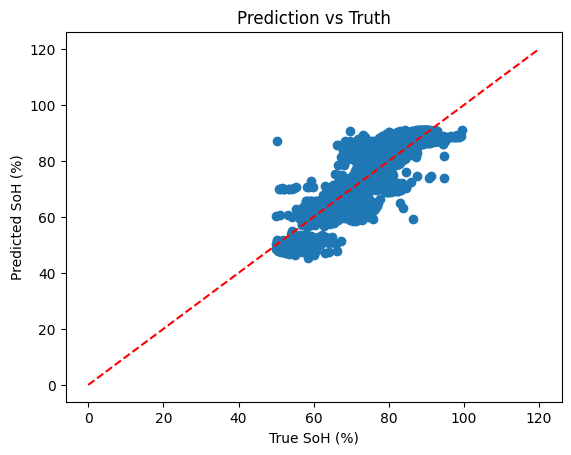

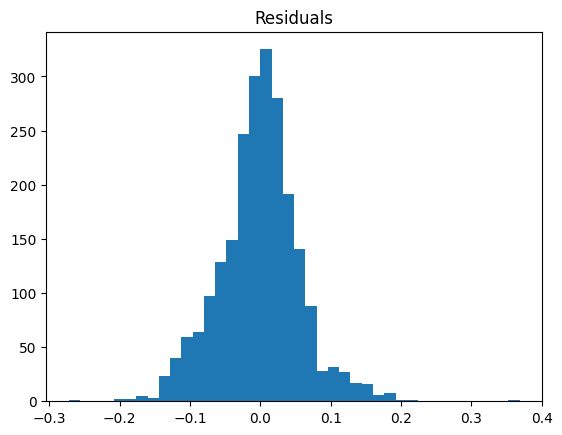

In [109]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X, _, _, SoH in loader:
        X = X.to(DEVICE)
        SoH_p, _, _ = model(X)
        y_true.append(SoH.numpy())
        y_pred.append(SoH_p.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

plt.figure()
plt.scatter(y_true * 100, y_pred * 100)
plt.plot([0,120],[0,120],'r--')
plt.xlabel("True SoH (%)")
plt.ylabel("Predicted SoH (%)")
plt.title("Prediction vs Truth")
plt.show()

plt.figure()
plt.hist(y_pred - y_true, bins=40)
plt.title("Residuals")
plt.show()
